This is the script for predicting which customer will spend what amount on food and beverages in a resort.
it - includes exploratory data analysis.
     Finding out what features are most important for predicting the dependent variable.
     Decision tree machine learning model has been used to predict the dependent variable.
     Root mean squared error is the used as the metrics to check the accuracy of prediction

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [95]:
df = pd.read_csv('train.csv')
df.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,...,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,05/04/18,05/04/18,06/04/18,3,1,2,0,46,3,...,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,23/01/15,11/04/15,16/04/15,1,1,2,0,46,3,...,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,28/01/15,01/02/15,05/02/15,1,1,2,0,47,1,...,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,02/05/15,11/06/15,16/06/15,1,1,2,2,46,2,...,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,02/09/15,14/12/15,19/12/15,1,1,2,0,46,2,...,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


First we study the dependent variable, which is - amount_spent_per_room_night_scaled.

In [96]:
df.amount_spent_per_room_night_scaled.describe()

count    341424.000000
mean          7.720801
std           1.090109
min           1.600397
25%           7.187260
50%           7.860814
75%           8.419144
max          10.816652
Name: amount_spent_per_room_night_scaled, dtype: float64

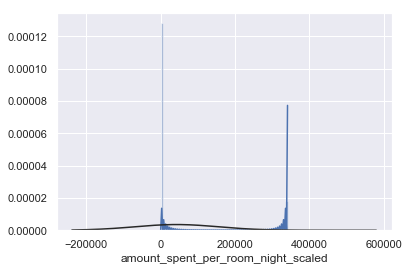

In [97]:
sns.distplot(df.amount_spent_per_room_night_scaled.describe(), fit=norm)

As the above plot describes out dependent variable is not normally distributed. So we will later scale this variable.
In the code cell below I am checking if there is any observation having a value equal to zero. In case if it contains any value equal to or less than zero, i'm going to delete the observatio considering it an outlier.

In [98]:
t = df.amount_spent_per_room_night_scaled == 0
t.sum()

0

After knowing somethings about my dependent variable, i'm going to create one new feature called 'stay_period from' the given features 'checkin_date' and 'checkout_date'.

In [99]:
df['checkin_date'] = pd.to_datetime(df.checkin_date, dayfirst=True)
df['checkout_date'] = pd.to_datetime(df.checkout_date, dayfirst=True)
df['stay_period'] = df['checkout_date'] - df['checkin_date']

In [100]:
df['stay_period'] = df['stay_period'].astype('timedelta64[D]')
df['stay_period'] = df['stay_period'].astype('int64')
df.stay_period.dtype

dtype('int64')

dropping the ovbservations for which the numberofadults and roomnights feature has zero and negative value because these are outliers both can not contain negative and zero values.

In [101]:
ind = df[df['numberofadults'] == 0].index
df.drop(ind, inplace=True)

In [102]:
ind_roomnights = []
ind_roomnights.extend(df[df['roomnights'] == 0].index)
ind_roomnights.extend(df[df['roomnights'] == -45].index)
ind_roomnights.extend(df[df['roomnights'] == 60].index)
ind_roomnights.extend(df[df['roomnights'] == 41].index)
ind_roomnights.extend(df[df['roomnights'] == 42].index)
ind_roomnights.extend(df[df['roomnights'] == 33].index)
df.drop(ind_roomnights, inplace=True)

creating new features such as total_members and num_of_rooms_booked 

In [103]:
df['total_members'] = df.numberofadults + df.numberofchildren

In [104]:
df['num_of_rooms'] = df.roomnights//df.stay_period

In [105]:
df.columns

Index(['reservation_id', 'booking_date', 'checkin_date', 'checkout_date',
       'channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid',
       'cluster_code', 'reservationstatusid_code', 'resort_id',
       'amount_spent_per_room_night_scaled', 'stay_period', 'total_members',
       'num_of_rooms'],
      dtype='object')

to study the relationship between dependent variable and categorical features, i will draw boxplots and check the importance of categorical features.


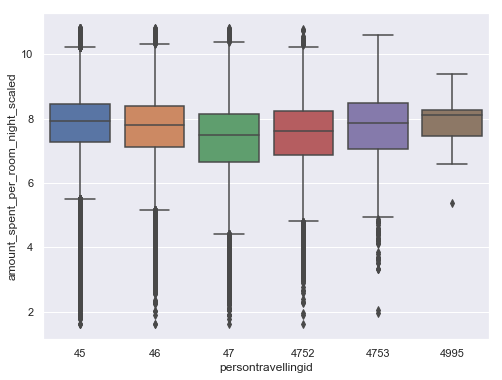

In [106]:
f,ax =plt.subplots(figsize=(8,6))
sns.boxplot(df['persontravellingid'],df['amount_spent_per_room_night_scaled'])

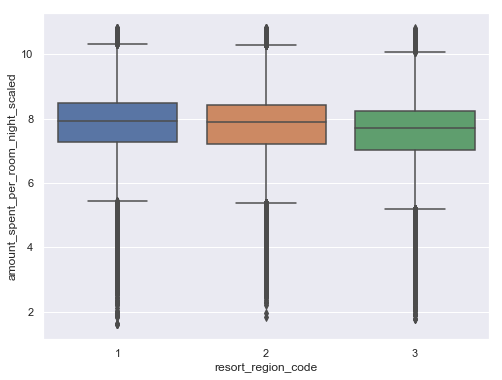

In [107]:
f,ax =plt.subplots(figsize=(8,6))
sns.boxplot(df['resort_region_code'],df['amount_spent_per_room_night_scaled'])

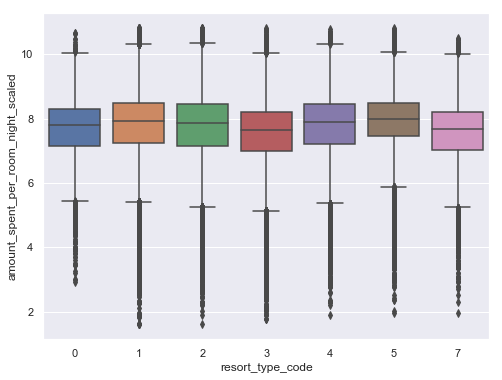

In [108]:
f,ax =plt.subplots(figsize=(8,6))
sns.boxplot(df['resort_type_code'],df['amount_spent_per_room_night_scaled'])

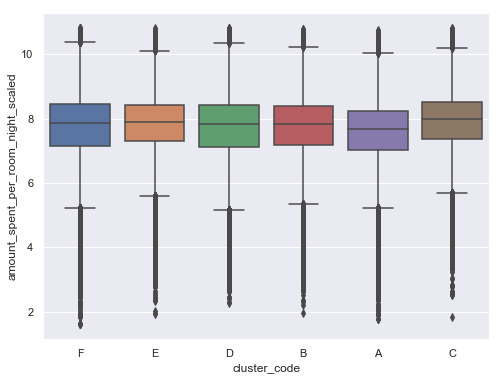

In [109]:
f,ax =plt.subplots(figsize=(8,6))
sns.boxplot(df['cluster_code'],df['amount_spent_per_room_night_scaled'])

from the above box plots i can see that none of the categorical features affect the dependent variable very strongly.
To study the over all correlation between the features i will plot a heatmap after obtaining the correlation matrix.

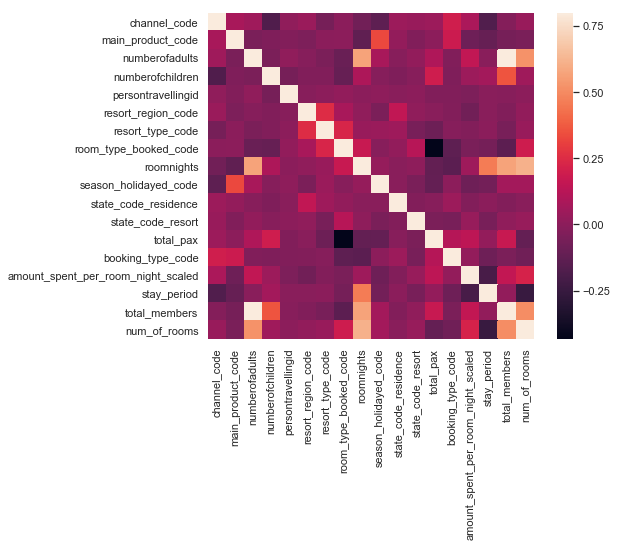

In [110]:
corrmat = df.corr()
f,ax =plt.subplots(figsize=(8,6))
sns.heatmap(corrmat, vmax=0.8, square=True)

from the above plot i can see that the variables 'roomnights', 'numofadults','total_members' and stay_period are highly correlated. So we can use any one of them which is related to the dependent variable the most.
Also the dependent variable does not show major correlation with any of the features. So i will plot a zoomed heatmap which will contain top 6 features according to thi highest correlation with dependent variables.

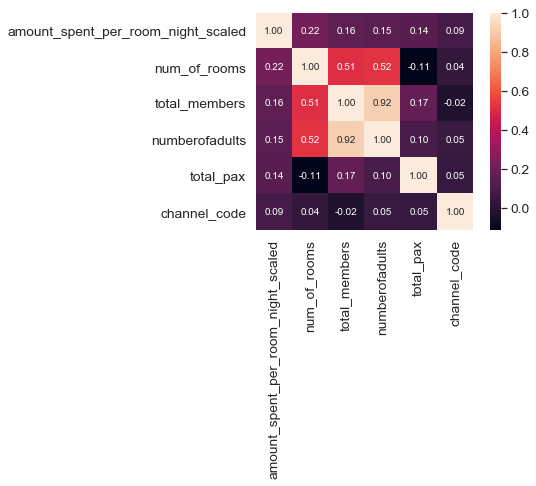

In [111]:
k = 6
cols = corrmat.nlargest(k,'amount_spent_per_room_night_scaled')['amount_spent_per_room_night_scaled'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10},
                yticklabels=cols.values, xticklabels=cols.values)
plt.show()

considering the above heatmap i will choose two features 'numberofadults' and 'total_pax' for my model.

After selecting the features now i will examine the pairplot between these variables and then scale the data and again plot the pairplot to see the distribution of scaled data.

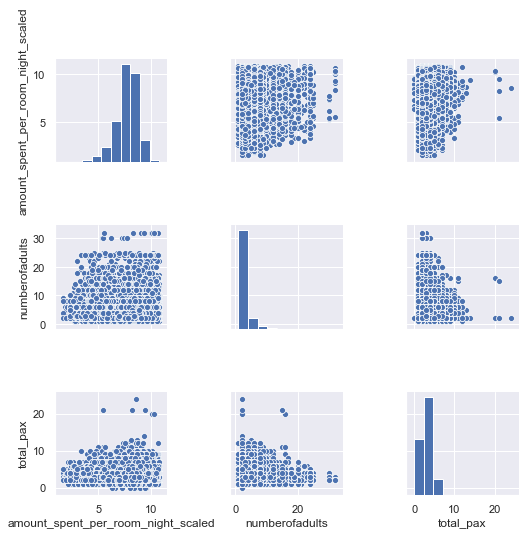

In [112]:
sns.set()
cols = ['amount_spent_per_room_night_scaled', 'numberofadults', 'total_pax']
sns.pairplot(df[cols])

In [113]:
df.isnull().sum()

reservation_id                           0
booking_date                             0
checkin_date                             0
checkout_date                            0
channel_code                             0
main_product_code                        0
numberofadults                           0
numberofchildren                         0
persontravellingid                       0
resort_region_code                       0
resort_type_code                         0
room_type_booked_code                    0
roomnights                               0
season_holidayed_code                  114
state_code_residence                  4760
state_code_resort                        0
total_pax                                0
member_age_buckets                       0
booking_type_code                        0
memberid                                 0
cluster_code                             0
reservationstatusid_code                 0
resort_id                                0
amount_spen

In [114]:
df.total_pax.value_counts()

2     106034
3      98494
4      97375
5      20670
6       8348
1       5912
7       3102
8       1093
9        229
10        74
11        18
0         16
12        13
21         3
13         2
20         2
14         1
24         1
Name: total_pax, dtype: int64

In [115]:
ind = df[df.total_pax == 0].index
df.drop(ind, inplace=True)

In [116]:
a_scaled = StandardScaler().fit_transform(df[['amount_spent_per_room_night_scaled']])[:,np.newaxis]

In [117]:
lrange = a_scaled[a_scaled[:,0].argsort()][:10]

In [118]:
hrange = a_scaled[a_scaled[:,0].argsort()][-10:]

In [119]:
print('lrange')
print(lrange)
print('hrange')
print(hrange)

lrange
[[[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]]
hrange
[[[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]


 [[[-0.01314292]]]]


In [120]:
#print(df.amount_spent_per_room_night_scaled.head(20))
#print(df.amount_spent_per_room_night_scaled.tail(-20))
print(df['amount_spent_per_room_night_scaled'][df.amount_spent_per_room_night_scaled >= 10])

25        10.211829
153       10.002341
160       10.127442
226       10.165684
282       10.247465
528       10.427920
845       10.209398
929       10.029184
959       10.498616
1635      10.510378
1937      10.085177
2052      10.203417
2107      10.129421
2112      10.060231
2258      10.093420
2537      10.488590
2538      10.577823
3261      10.622026
3633      10.409883
3946      10.161398
4000      10.046923
4706      10.261418
4912      10.171336
5228      10.187167
5244      10.298633
5245      10.305277
5247      10.341456
5250      10.460706
5251      10.296934
5279      10.014828
            ...    
337644    10.613531
337733    10.033095
337937    10.204623
338067    10.497164
338184    10.590411
338251    10.366213
338365    10.027732
338436    10.488946
338846    10.165296
338971    10.185467
339125    10.063480
339469    10.267772
339607    10.153246
339679    10.337022
339998    10.009093
340066    10.249978
340272    10.415474
340429    10.243399
340454    10.143773


In [121]:
df['amount_spent_per_room_night_scaled'] = np.log(df['amount_spent_per_room_night_scaled']+1)

In [122]:
df['numberofadults'] = np.log(df['numberofadults']+1)
df['total_pax'] = np.log(df['total_pax']+1)

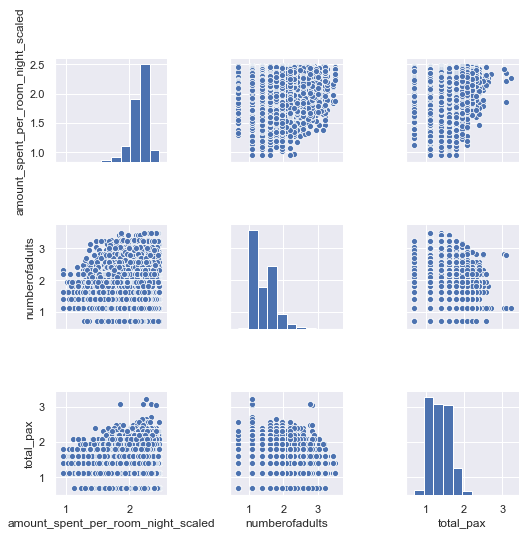

In [123]:
sns.set()
cols = ['amount_spent_per_room_night_scaled', 'numberofadults', 'total_pax']
sns.pairplot(df[cols])

In [124]:
from sklearn.model_selection import train_test_split, cross_validate
cols = ['numberofadults', 'total_pax']
X = df[cols].copy()
y = df['amount_spent_per_room_night_scaled']

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

I am going to use GradientBoosting regressor and cross_validate to find the best estimator which gives the least MSE error.
I will choose that estimator to predict on my test set.

In [126]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE
gb = GradientBoostingRegressor()
cv2 = cross_validate(gb, X_train, y_train, scoring='neg_mean_squared_error', return_estimator=True, cv=5) 

In [127]:
cv2

{'fit_time': array([6.40380692, 6.30366755, 6.51242113, 6.43453455, 6.27649021]),
 'score_time': array([0.09409142, 0.10783458, 0.09144115, 0.07977438, 0.10706735]),
 'estimator': (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=100, n_iter_no_change=None, presort='auto',
               random_state=None, subsample=1.0, tol=0.0001,
               validation_fraction=0.1, verbose=0, warm_start=False),
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,


In [128]:
p1 = cv2['estimator'][0].predict(X_test)

In [129]:
mse = MSE(y_test,p1)
print(np.sqrt(mse))

0.1351158410794833


In [131]:
test = pd.read_csv('test.csv')

In [132]:
test['numberofadults'] = np.log(test['numberofadults']+1)
test['total_pax'] = np.log(test['total_pax']+1)

In [133]:
cols = ['numberofadults', 'total_pax']
Xt = test[cols].copy()

In [134]:
y_pred = cv2['estimator'][0].predict(X_test)

In [135]:
tt = cv2['estimator'][0].predict(Xt)